In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import sys
import os

# Add the src directory to the Python path
src_path = os.path.join(os.getcwd(), 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

In [18]:
import ast
import csv
import itertools
import random
from itertools import product
import numpy as np
import pandas as pd

from loss_functions import *
from src.activation_functions import *
from src.batch_normalization import *
from src.data_preprocessing import *
from src.ensemble.cascade_correlation import CascadeCorrelation
from src.k_fold_cross_validation import *
from src.layer import *
from src.early_stopping import EarlyStopping
from src.neural_network import *
from src.optimizers import *
from src.random_search import *
from src.train_and_evaluate import Train
from src.utils import *

# from src.random_search import *

np.random.seed(0)

<!-- #### Data pre-processing for MONK Datasets  -->

In [19]:
X_train, y_train = load_data(MONK_NUM=2)
X_test, y_test = load_data(MONK_NUM=2, train=False)

one hot encoded data:  (169, 17)
one hot encoded data:  (432, 17)


In [20]:
X_train, X_val = train_test_split(X_train)
y_train, y_val = train_test_split(y_train)
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_val = np.asarray(X_val)
y_val = np.asarray(y_val)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [21]:
print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))

Training set size: 135
Validation set size: 34


In [22]:
# Print the shape of the resulting datasets
for _ in [X_train, X_val, y_train, y_val]:
    print(f"the shape: ", _.shape)

the shape:  (135, 17)
the shape:  (34, 17)
the shape:  (135, 1)
the shape:  (34, 1)


In [23]:
param_distributions = {
    'hidden_size': [3, 4, 5, 6, 8],
    'n_h_layers': [1, 2, 3],
    'hidden_activation': [Activation_Tanh, Activation_Leaky_ReLU, Activation_Sigmoid, Activation_ReLU],
    'batch_norm': [True, False],
    'learning_rate': [1e-2, 1e-4, 1e-3, 2e-4,1e-6, 1e-5],
    'l1': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2],
    'l2': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2],
    'dropout_rate': [0.0, 0.1, 0.3],
    'batch_size': [8, 16, 32],
    'n_epochs': [100, 150, 200, 250, 300],
    'weight_decay': [0, 5e-2, 1e-2, 1e-3, 1e-4, 1e-5],
    'patience': [0, 20, 30, 50],
    'CC': [False],
    'weights_init': ['gaussian', 'gaussian_scaled', 'xavier', 'he', 'random'],
    # # Define combinations of hidden layer sizes and corresponding activations
    # 'hidden_configs': [
    #     {'hidden_size': [10], 'hidden_activation': [Activation_Tanh], 'batch_norm' : [True]},
    #     {'hidden_size': [10, 10], 'hidden_activation': [Activation_Leaky_ReLU, Activation_ELU], 'batch_norm' : [True, True]},
    #     {'hidden_size': [10, 10], 'hidden_activation': [Activation_Leaky_ReLU, Activation_ELU], 'batch_norm' : [True, True]},
    #     {'hidden_size': [20, 20], 'hidden_activation': [Activation_Leaky_ReLU, Activation_ELU], 'batch_norm' : [True, False]},
    #     {'hidden_size': [20, 20], 'hidden_activation': [Activation_Leaky_ReLU, Activation_ELU], 'batch_norm' : [True, True]},
    #     {'hidden_size': [20, 20], 'hidden_activation': [Activation_ELU, Activation_ELU], 'batch_norm' : [True, False]},
    #     {'hidden_size': [10, 10], 'hidden_activation': [Activation_Leaky_ReLU, Activation_ELU], 'batch_norm' : [True, False]},
    #     {'hidden_size': [32, 16], 'hidden_activation': [Activation_Leaky_ReLU, Activation_Sigmoid], 'batch_norm' : [False, True]},  
    #     {'hidden_size': [30, 30], 'hidden_activation': [Activation_Leaky_ReLU, Activation_ELU], 'batch_norm' : [True, False]},
    #     {'hidden_size': [64, 32, 16], 'hidden_activation': [Activation_ReLU, Activation_ReLU, Activation_Tanh], 'batch_norm' : [True, False, True]},
    #     {'hidden_size': [30, 30], 'hidden_activation': [Activation_Leaky_ReLU, Activation_ELU], 'batch_norm': [True, False]}
    # ]   
}

TODO:

Create a seperate best_results csv file for each MONK 

In [24]:
best_hyperparams, best_performance = random_search(X_train=X_train, y_train=y_train, param_distributions=param_distributions, n_iters=50)  # adjust n_iters as needed

print(best_hyperparams)

8 <class 'src.activation_functions.Activation_Tanh'> 0.3 False
Data shapes:
X_train: (108, 17), y_train: (108, 1)
Hyperparams: {'hidden_size': 8, 'n_h_layers': 2, 'hidden_activation': <class 'src.activation_functions.Activation_Tanh'>, 'batch_norm': False, 'learning_rate': 0.0002, 'l1': 1e-05, 'l2': 0.001, 'dropout_rate': 0.3, 'batch_size': 32, 'n_epochs': 100, 'weight_decay': 1e-05, 'patience': 50, 'CC': False, 'weights_init': 'gaussian_scaled'}
Epoch 0: Train Loss: 0.2559, Acc: 38.28% | Val Loss: 0.2514, Acc: 37.04%
Epoch 10: Train Loss: 0.2446, Acc: 64.84% | Val Loss: 0.2505, Acc: 51.85%
Epoch 20: Train Loss: 0.2277, Acc: 68.49% | Val Loss: 0.2518, Acc: 51.85%
Epoch 30: Train Loss: 0.2353, Acc: 66.67% | Val Loss: 0.2539, Acc: 51.85%
Epoch 40: Train Loss: 0.2162, Acc: 66.67% | Val Loss: 0.2565, Acc: 51.85%
Epoch 50: Train Loss: 0.2297, Acc: 66.67% | Val Loss: 0.2594, Acc: 51.85%
Early stopping at epoch 59
Restoring model weights from epoch 9
Final Validation score: 0.5185
✅ Fold 1/5 

In [25]:
print(best_hyperparams)

{'hidden_size': 3, 'n_h_layers': 2, 'hidden_activation': <class 'src.activation_functions.Activation_Tanh'>, 'batch_norm': False, 'learning_rate': 0.01, 'l1': 1e-05, 'l2': 1e-06, 'dropout_rate': 0.3, 'batch_size': 8, 'n_epochs': 100, 'weight_decay': 0, 'patience': 50, 'CC': False, 'weights_init': 'gaussian_scaled', 'val_accuracy': np.float64(0.7333333333333332)}


GRID SEARCH

3 <class 'src.activation_functions.Activation_Tanh'> 0.3 False
Data shapes:
X_train: (135, 17), y_train: (135, 1)
Hyperparams: {'hidden_size': 3, 'n_h_layers': 2, 'hidden_activation': <class 'src.activation_functions.Activation_Tanh'>, 'batch_norm': False, 'learning_rate': 0.01, 'l1': 1e-05, 'l2': 1e-06, 'dropout_rate': 0.3, 'batch_size': 8, 'n_epochs': 100, 'weight_decay': 0, 'patience': 50, 'CC': False, 'weights_init': 'gaussian_scaled', 'val_accuracy': np.float64(0.7333333333333332)}
Epoch 0: Train Loss: 0.2445, Acc: 63.03% | Val Loss: 0.2861, Acc: 41.18%
Epoch 10: Train Loss: 0.2210, Acc: 69.64% | Val Loss: 0.2645, Acc: 52.94%
Epoch 20: Train Loss: 0.2237, Acc: 63.13% | Val Loss: 0.2606, Acc: 55.88%
Epoch 30: Train Loss: 0.2104, Acc: 64.71% | Val Loss: 0.2585, Acc: 50.00%
Epoch 40: Train Loss: 0.2057, Acc: 65.97% | Val Loss: 0.2622, Acc: 47.06%
Epoch 50: Train Loss: 0.1910, Acc: 72.69% | Val Loss: 0.2618, Acc: 50.00%
Epoch 60: Train Loss: 0.2211, Acc: 61.97% | Val Loss: 0.2531, Acc

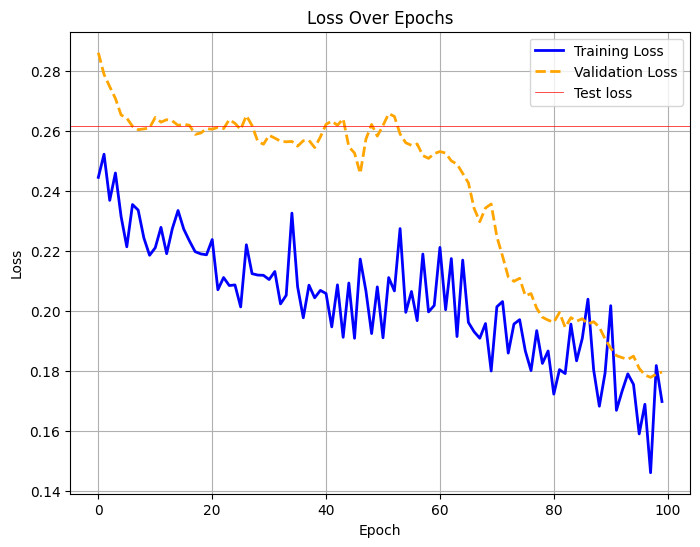

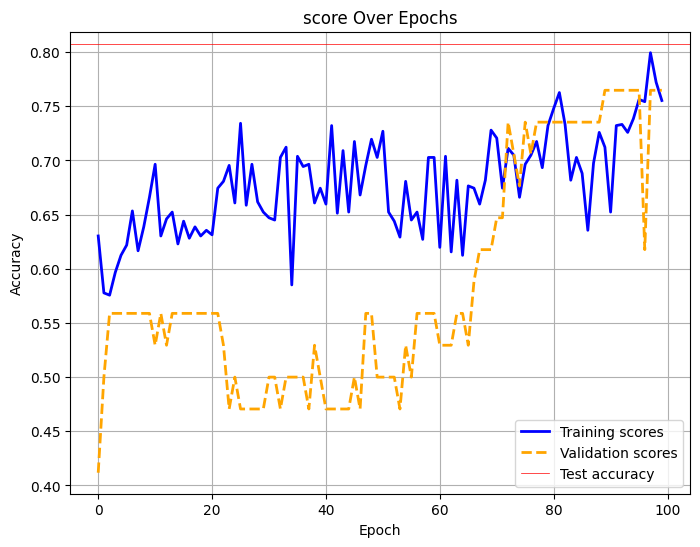

In [26]:
if best_hyperparams['CC']:
    model = CascadeCorrelation(input_size = 17, output_size= 1, activation=Activation_Leaky_ReLU, output_activation = Activation_Sigmoid)
else:
    model = NN(
        l1=best_hyperparams['l1'],
        l2=best_hyperparams['l2'],
        input_size=17,
        hidden_size=best_hyperparams['hidden_size'],
        output_size=1,
        hidden_activation=best_hyperparams['hidden_activation'],
        dropout_rate=best_hyperparams['dropout_rate'],
        use_batch_norm=best_hyperparams['batch_norm'],
        n_h_layers=best_hyperparams['n_h_layers']
    )

train = Train(best_hyperparams, model)
train.train_and_evaluate(X_train, y_train, X_val, y_val)
train.test(X_test, y_test)
train.plot(score=True)

In [27]:
print(train.train_losses, train.val_losses)

[np.float64(0.2444943920022323), np.float64(0.2522232572562264), np.float64(0.23682026216549149), np.float64(0.24595422882463705), np.float64(0.23140375344791297), np.float64(0.22132563870629007), np.float64(0.23542772471396384), np.float64(0.23356970844731703), np.float64(0.22426813346913851), np.float64(0.21850443538042125), np.float64(0.22101939412469454), np.float64(0.22781194001789615), np.float64(0.2190268888227778), np.float64(0.22740170417524105), np.float64(0.233435353953743), np.float64(0.22723673779998563), np.float64(0.2233014958816515), np.float64(0.21970897196546144), np.float64(0.21895673170640367), np.float64(0.21866046871827627), np.float64(0.22374824244420535), np.float64(0.20700352458260782), np.float64(0.2110707338222505), np.float64(0.20840550528778973), np.float64(0.20860117744807538), np.float64(0.2012663849198706), np.float64(0.22200777914197206), np.float64(0.2123684319732984), np.float64(0.2118984601375877), np.float64(0.21181478129133013), np.float64(0.210401

In [28]:
print(f"Test Accuracy: {train.test_score:.4f}")

Test Accuracy: 0.8079


In [29]:
class EnsembleNN:
    def __init__(self, n_models=5):
        self.models = []
        self.n_models = n_models
        self.loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
        

    def create_and_train_models(self, hyperparams):
        # Create and train multiple models with the same hyperparameters
        for i in range(self.n_models):
            model = NN(
                l1=hyperparams['l1'],
                l2=hyperparams['l2'],
                input_size=17,
                hidden_size=hyperparams['hidden_size'],
                output_size=1,
                hidden_activation=hyperparams['hidden_activation'],
                dropout_rate=hyperparams['dropout_rate'],
                use_batch_norm=hyperparams['batch_norm'],
                n_h_layers=hyperparams['n_h_layers']
            )
            print(f"Training model {i+1}/{self.n_models}")
            # Train model using existing train_and_evaluate function
            self.train = Train(hyperparams, model)
            model, val_accuracy = self.train.train_and_evaluate(
                X_train=X_train,
                y_train=y_train,
                X_val=X_val,
                y_val=y_val,
            )
            self.models.append(model)
            print(f"Model {i+1} validation accuracy: {val_accuracy:.4f}")

    def predict(self, X):
        """Make predictions using majority voting"""
        predictions = []
        for model in self.models:
            model.forward(X, training=False)
            self.loss_activation.forward(
                model.output, np.zeros((X.shape[0], 2)))  # Dummy y values
            pred = np.argmax(self.loss_activation.output, axis=1)
            predictions.append(pred)

        # Majority voting
        predictions = np.array(predictions)
        final_predictions = np.apply_along_axis(
            lambda x: np.bincount(x).argmax(),
            axis=0,
            arr=predictions
        )
        return final_predictions

3 <class 'src.activation_functions.Activation_Tanh'> 0.3 False
Training model 1/5
Data shapes:
X_train: (135, 17), y_train: (135, 1)
Hyperparams: {'hidden_size': 3, 'n_h_layers': 2, 'hidden_activation': <class 'src.activation_functions.Activation_Tanh'>, 'batch_norm': False, 'learning_rate': 0.01, 'l1': 1e-05, 'l2': 1e-06, 'dropout_rate': 0.3, 'batch_size': 8, 'n_epochs': 100, 'weight_decay': 0, 'patience': 50, 'CC': False, 'weights_init': 'gaussian_scaled', 'val_accuracy': np.float64(0.7333333333333332)}
Epoch 0: Train Loss: 0.2854, Acc: 53.15% | Val Loss: 0.2444, Acc: 58.82%
Epoch 10: Train Loss: 0.2184, Acc: 65.23% | Val Loss: 0.2815, Acc: 50.00%
Epoch 20: Train Loss: 0.2260, Acc: 61.45% | Val Loss: 0.2787, Acc: 47.06%
Epoch 30: Train Loss: 0.2288, Acc: 61.55% | Val Loss: 0.2812, Acc: 47.06%
Epoch 40: Train Loss: 0.2032, Acc: 68.17% | Val Loss: 0.2775, Acc: 50.00%
Epoch 50: Train Loss: 0.1800, Acc: 70.48% | Val Loss: 0.2321, Acc: 52.94%
Epoch 60: Train Loss: 0.1913, Acc: 68.38% | Va

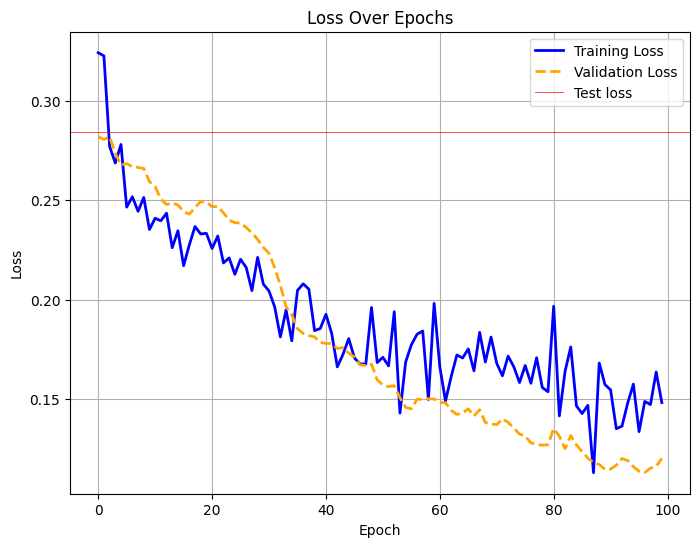

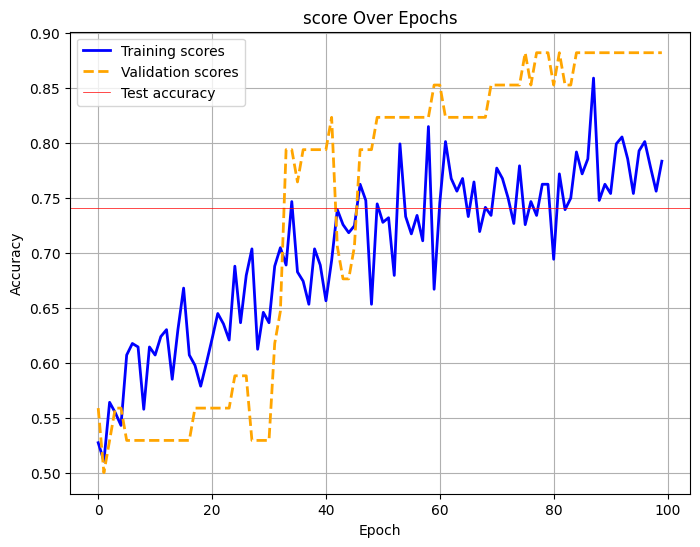

In [30]:
ensemble = EnsembleNN(n_models=5)

ensemble.create_and_train_models(best_hyperparams)

_ , test_accuracy = ensemble.train.test(X_test, y_test)

print(f"Ensemble Test Accuracy: {test_accuracy:.4f}")

ensemble.train.plot(score=True)